In [1]:
# package dependencies and suppress unnecessary warning messages 
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, NumbaWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaWarning)

In [2]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [3]:
pd.set_option('display.max_columns', 40)

In [4]:
import harmonypy

In [5]:
# reproducibility
seed = 10
np.random.seed(seed)

In [66]:
adata_1a = sc.read_h5ad("data/PBMMC_1a_dimRed.h5ad")

In [67]:
adata_1b = sc.read_h5ad("data/PBMMC_1b_dimRed.h5ad")

In [68]:
adata_1a.shape

(846, 24207)

In [69]:
adata_1b.shape

(1177, 24016)

In [70]:
adata_1a.var = adata_1a.var.astype(str)
adata_1b.var = adata_1b.var.astype(str)

In [71]:
adata_combined = ad.concat([adata_1a, adata_1b], join = 'inner', merge = 'same', keys=['batch_1', 'batch_2'], index_unique='_', label='batch')

In [72]:
adata_combined

AnnData object with n_obs × n_vars = 2023 × 21749
    obs: 'Barcode', 'sizeFactor', 'label', 'batch'
    var: 'ID', 'Symbol', 'Chromosome'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [73]:
adata_combined_counts = adata_combined.copy()

In [74]:
adata_combined.X.max()

6486.0

In [75]:
adata_combined.obs

,Barcode,sizeFactor,label,batch
AAACCTGCACTTCGAA-1_batch_1,AAACCTGCACTTCGAA-1,0.521288,8,batch_1
AAACCTGCAGACGCAA-1_batch_1,AAACCTGCAGACGCAA-1,0.568532,9,batch_1
AAAGATGCATAAAGGT-1_batch_1,AAAGATGCATAAAGGT-1,0.472943,4,batch_1
AAAGATGTCTCGAGTA-1_batch_1,AAAGATGTCTCGAGTA-1,0.217871,8,batch_1
AAAGCAACAATACGCT-1_batch_1,AAAGCAACAATACGCT-1,0.414777,14,batch_1
...,...,...,...,...
TTTATGCTCGTTGCCT-1_batch_2,TTTATGCTCGTTGCCT-1,0.491334,8,batch_2
TTTGGTTAGTCTCGGC-1_batch_2,TTTGGTTAGTCTCGGC-1,0.300197,4,batch_2
TTTGTCAGTAAATGTG-1_batch_2,TTTGTCAGTAAATGTG-1,1.311460,2,batch_2
TTTGTCAGTACAAGTA-1_batch_2,TTTGTCAGTACAAGTA-1,0.504132,8,batch_2


In [76]:
batch_key = "batch"

## 3.  Data integration
### 1. First check unintegrated data

In [77]:
# standard analysis without considering batch

adata_combined.layers["counts"] = adata_combined.X.copy()
sc.pp.normalize_total(adata_combined)
sc.pp.log1p(adata_combined)
adata_combined.layers["logcounts"] = adata_combined.X.copy()

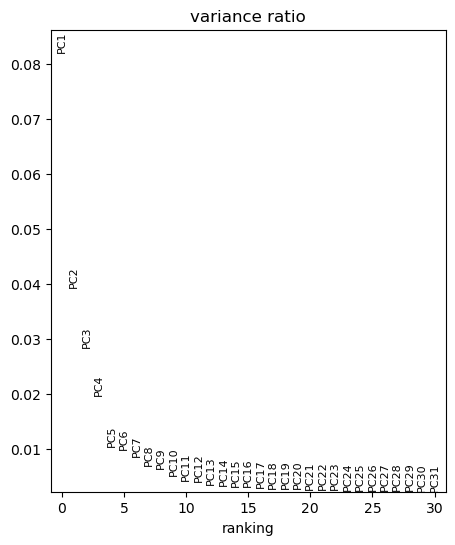

In [78]:
sc.pp.highly_variable_genes(adata_combined, flavor='seurat')
sc.tl.pca(adata_combined)
sc.pl.pca_variance_ratio(adata_combined, n_pcs=30, log=False, show=None, save=None)

In [79]:
sc.pp.neighbors(adata_combined, n_pcs=20)
sc.tl.umap(adata_combined)
adata_combined

AnnData object with n_obs × n_vars = 2023 × 21749
    obs: 'Barcode', 'sizeFactor', 'label', 'batch'
    var: 'ID', 'Symbol', 'Chromosome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

In [80]:
matplotlib.rcParams['figure.figsize'] = [3, 6]

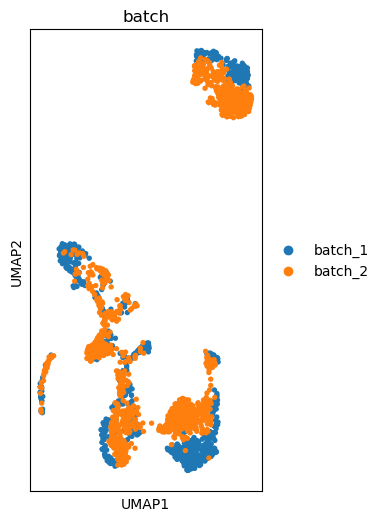

In [81]:
sc.pl.umap(adata_combined, color=[batch_key], wspace=1, ncols=1)

### 2. Batch-aware feature selection

In [82]:
# add batch_key when selecting HVGs
# this will overwrite the previous HVGs-related column values in the .var table and add some new columns
sc.pp.highly_variable_genes(
    adata_combined, n_top_genes=2000, flavor="cell_ranger", batch_key=batch_key
)

In [83]:
adata_combined

AnnData object with n_obs × n_vars = 2023 × 21749
    obs: 'Barcode', 'sizeFactor', 'label', 'batch'
    var: 'ID', 'Symbol', 'Chromosome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

In [84]:
# Note the highly_variable_nbatches and the highly_variable_intersection column
adata_combined.var

,ID,Symbol,Chromosome,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
ENSG00000238009,ENSG00000238009,ENSG00000238009,chr1,False,0.001109,0.596376,0.131413,0,False
ENSG00000241860,ENSG00000241860,ENSG00000241860,chr1,True,0.002073,0.825203,1.389519,1,False
ENSG00000237491,ENSG00000237491,LINC01409,chr1,False,0.023695,0.729940,0.248438,0,False
ENSG00000225880,ENSG00000225880,LINC00115,chr1,False,0.002493,0.814119,0.528333,0,False
ENSG00000228794,ENSG00000228794,LINC01128,chr1,False,0.010685,0.603632,-1.155363,0,False
...,...,...,...,...,...,...,...,...,...
ENSG00000276256,ENSG00000276256,ENSG00000276256,GL000195.1,False,0.002689,0.343913,-1.814459,0,False
ENSG00000273748,ENSG00000273748,ENSG00000273748,GL000219.1,False,0.035194,0.764593,0.561928,0,False
ENSG00000271254,ENSG00000271254,ENSG00000271254,KI270711.1,False,0.017971,0.809606,0.911032,0,False
ENSG00000276017,ENSG00000276017,ENSG00000276017,KI270734.1,False,0.000256,0.273243,-0.454976,0,False


highly_variable_nbatches
0    18430
1     2638
2      681
Name: count, dtype: int64

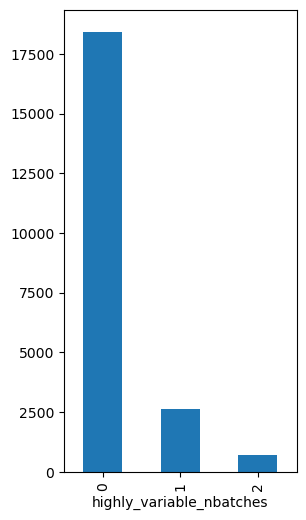

In [85]:
# see how many batches the gene is highly variable in

n_batches = adata_combined.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

### 3. example: integration with harmony

In [86]:
# move the unintegrated umap
adata_combined.obsm['X_umapraw'] = adata_combined.obsm['X_umap']

In [87]:
# run harmony via scanpy external API
sc.external.pp.harmony_integrate(adata_combined, key=batch_key, basis = 'X_pca')

2024-08-23 13:07:56,733 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-08-23 13:07:57,796 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-08-23 13:07:57,801 - harmonypy - INFO - Iteration 1 of 10
2024-08-23 13:07:57,964 - harmonypy - INFO - Iteration 2 of 10
2024-08-23 13:07:58,125 - harmonypy - INFO - Iteration 3 of 10
2024-08-23 13:07:58,288 - harmonypy - INFO - Iteration 4 of 10
2024-08-23 13:07:58,358 - harmonypy - INFO - Iteration 5 of 10
2024-08-23 13:07:58,414 - harmonypy - INFO - Iteration 6 of 10
2024-08-23 13:07:58,469 - harmonypy - INFO - Converged after 6 iterations


In [88]:
# Note that a new embedding, which we named X_pca_harmony is generated
adata_combined

AnnData object with n_obs × n_vars = 2023 × 21749
    obs: 'Barcode', 'sizeFactor', 'label', 'batch'
    var: 'ID', 'Symbol', 'Chromosome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_umapraw', 'X_pca_harmony'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

In [89]:
# recalculate neighbours and umap based on harmony corrected embedding

sc.pp.neighbors(adata_combined, use_rep='X_pca_harmony', key_added = 'harmony', n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_combined, neighbors_key = 'harmony')

In [90]:
matplotlib.rcParams['figure.figsize'] = [5, 6]

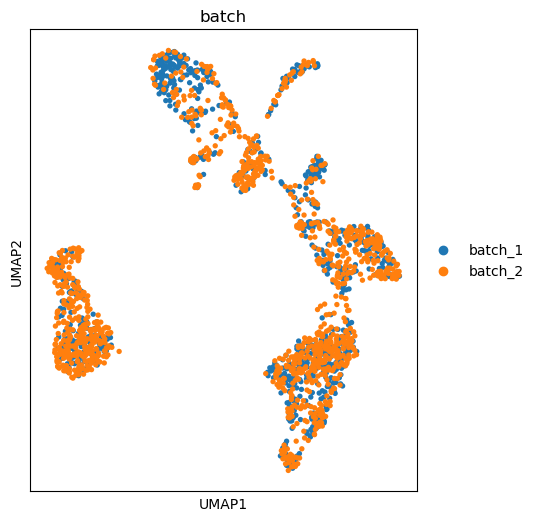

In [91]:
sc.pl.umap(adata_combined, color=[batch_key], ncols=1)

In [92]:
# move harmony corrected umap
adata_combined.obsm['X_umapharmony'] = adata_combined.obsm['X_umap']

#### SCVI integration

In [93]:
import scvi

In [96]:
 adata_combined_counts.layers['counts'] =  adata_combined_counts.X.copy()

In [97]:
## batch-aware HVG selection on counts is required for scVI

In [98]:
sc.pp.highly_variable_genes(
    adata_combined_counts,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="batch",
    subset=True,
)

In [99]:
scvi.model.SCVI.setup_anndata(adata_combined, layer="counts", batch_key="batch")

In [102]:
model = scvi.model.SCVI(adata_combined, n_layers=2, n_latent=30, gene_likelihood="nb")

In [103]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [18:41<00:00,  2.75s/it, v_num=1, train_loss_step=4.65e+3, train_loss_epoch=4.13e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [18:41<00:00,  2.80s/it, v_num=1, train_loss_step=4.65e+3, train_loss_epoch=4.13e+3]


In [104]:
SCVI_LATENT_KEY = "X_scVI"
adata_combined.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [106]:
sc.pp.neighbors(adata_combined, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata_combined)

/tmp/ipykernel_4126107/4179760100.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_combined)


In [107]:
SCVI_MDE_KEY = "X_scVI_MDE"
adata_combined.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata_combined.obsm[SCVI_LATENT_KEY])

sc.pl.embedding(
    adata_combined,
    basis=SCVI_MDE_KEY,
    color=["batch", "leiden"],
    frameon=False,
    ncols=1,
)

ImportError: Please install pymde package via `pip install pymde`